## Dataset preparation

In [13]:
#pip install -e .
#pip install  abbyy_course_cvdl_t2

from pathlib import Path
from course_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import wandb

import torch

from task1pack.utils.data import HeatmapDataset

In [14]:
torch.manual_seed(42)

In [15]:
#DATASET_PATH = Path() / '..' / '..' / 'data' / 'midv500_compressed'
DATASET_PATH = Path() / '..' / '..' / '..' / '..' / '..' / '..' / 'Downloads' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

In [18]:
from torchvision.transforms import Resize, Compose, ToTensor

IMAGE_SIZE = [416, 416]
HEATMAP_SIZE = [104, 104]

transforms = Compose([
    ToTensor(),
    Resize(IMAGE_SIZE),
])

train_dataset = HeatmapDataset(data_packs=data_packs, split='train', transforms=transforms, output_size=HEATMAP_SIZE)
test_dataset = HeatmapDataset(data_packs=data_packs, split='test', transforms=transforms, output_size=HEATMAP_SIZE)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

(10750, 4250)

## Experiment

In [20]:
from task1pack.models.centernet import CenterNet

from task1pack.utils.train import train_model, show_train_plots

from torch.nn import MSELoss

In [21]:
centernet = CenterNet(pretrained="resnet34", head_kwargs={'c_classes': 4})

In [28]:
train_dataloader_config = {
    'batch_size': 8,
    'shuffle': True,
}

test_dataloader_config = {
    'batch_size': 8,
    'shuffle': False,
}

training_config = {
    'lr': 1e-3,
    'epochs': 2,
    'step_size': 1,
    'gamma': 0.1,
}

device = 'cuda:0'
criterion = MSELoss()

wandb.init(
    project='ocr task 1',
    name='Centernet 1 epoch',
    config={
        'train_dataloader_config': train_dataloader_config,
        'test_dataloader_config': test_dataloader_config,
        'training_config': training_config,

    "architecture": "CenterNet",
    "dataset": "MIDV-500",
    "criterion": "MSELoss",
    "optimizer": "Adam",
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vashchilkoav. Use `wandb login --relogin` to force relogin


In [29]:
train_losses, test_losses, trained_centernet = train_model(
    train_dataset=train_dataset, 
    test_dataset=test_dataset, 
    model=centernet, 
    train_dataloader_kwargs=train_dataloader_config, 
    test_dataloader_kwargs=test_dataloader_config, 
    training_kwargs=training_config,
    criterion=criterion,
    device=device,
    wandb_instance=wandb,
)

initial loss 0.11531134694814682
epoch 0 started
train loss: 0.03533503866163387, test_loss: 0.013898993842303753


lr,▁
lr,0.001


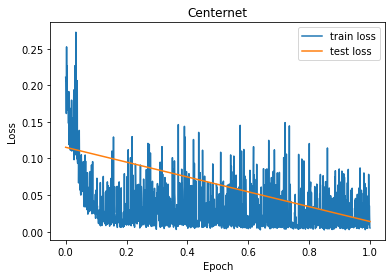

In [30]:
show_train_plots(train_losses, test_losses, 'Centernet')

### Сохраним результаты и измерим точность
Результаты - словарь с ключем DataItem.unique_key() и значением предсказанным quadrangle в относительных единицах.

In [32]:
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

results_dict = {}

trained_model.eval()

with torch.no_grad():
    for i, (x, _) in tqdm(enumerate(test_dataset)):
        result = trained_model(x[None, ...].to(device))[0]
        key = test_dataset.get_key(i)
        results_dict[key] = result.cpu().tolist()

dump_results_dict(results_dict, Path() / 'pred.json')

acc_95 = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

acc_80 = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json',
    iou_thr=0.8
)

wandb.run.summary['acc@95'] = acc_95
wandb.run.summary['acc@80'] = acc_80
wandb.log({'predictions': wandb.JSON(Path() / 'pred.json')})

wandb.finish()

4250it [02:53, 24.51it/s]
